In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_2_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s11_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((78,2))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 2
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 4


Create uniform log prior

In [5]:

# Define the size of the list
size = 4
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_25885/1193693380.py:23: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     252     0:00.8
2     498     0:01.3
3     738     0:01.8
20    3879    0:08.6
40    6579    0:14.8
60    9381    0:21.1
80    12147   0:27.4
100   15015   0:33.7
120   17886   0:40.2
140   20775   0:46.7
160   23607   0:53.0
180   26277   0:58.9
200   29163   1:05.3
220   31863   1:11.3
240   34704   1:17.6
260   37566   1:24.0
280   40452   1:30.4
300   43098   1:36.3
320   45948   1:42.6
340   48978   1:49.3
360   51987   1:56.0
380   54807   2:02.3
400   57765   2:08.9
420   60573   2:15.1
440   63531   2:21.6
460   66555   2:28.3
480   69462   2:34.7
500   72237   2:40.9
520   75267   2:47.6
540   78240   2:54.1
560   81000   3:00.2
580   83745   3:06.4
600   86640   3:12.7
620   89457   3:19.0
640   92277   3:25.3
660   95199   3:31.8
680   98055   3:38.1
700   101019   3:44.6
720   103977   3:51.1
740   106902   3:57.6
760   109542   4:03.4
780   112392

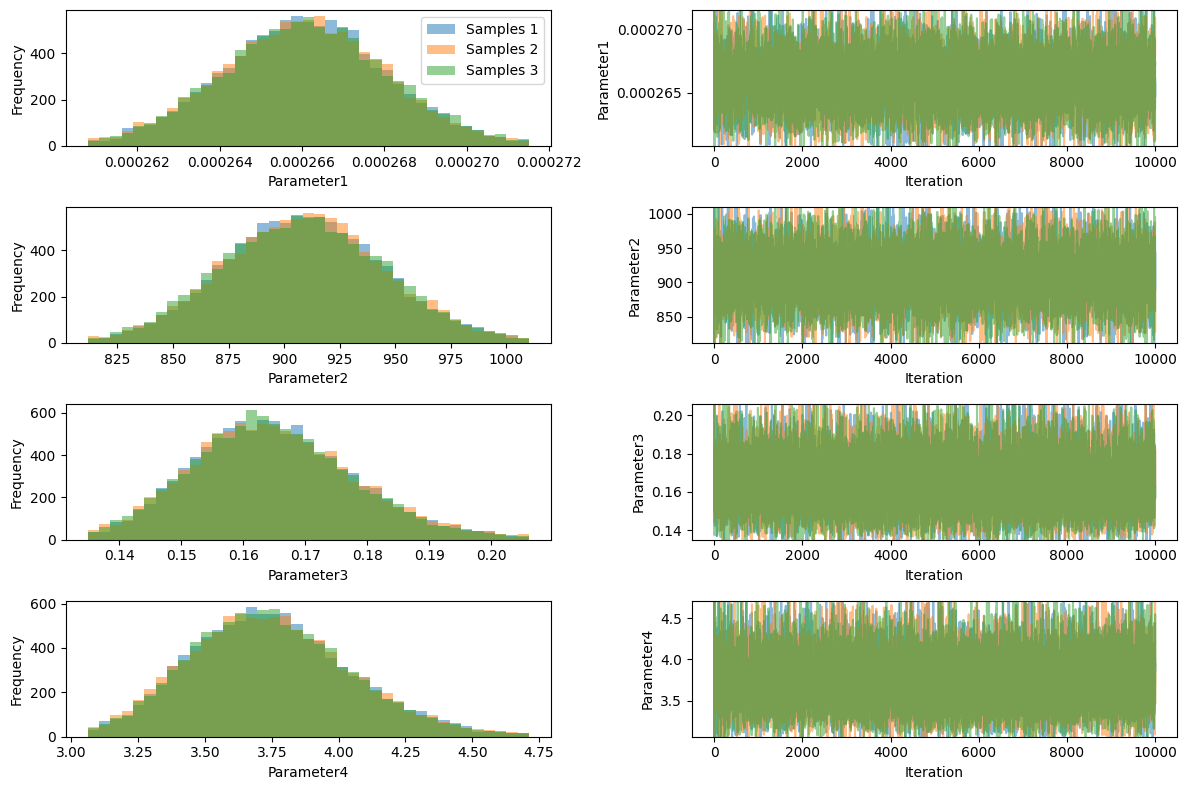

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,100:1000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 4)
[2.67408489e-04 8.88709961e+02 1.46810457e-01 3.75713425e+00]
[[2.67408489e-04 8.88709961e+02 1.46810457e-01 3.75713425e+00]
 [2.66374375e-04 9.24743510e+02 1.68090208e-01 3.91526125e+00]
 [2.65188292e-04 9.29345138e+02 1.74589999e-01 3.57039113e+00]
 ...
 [2.63425135e-04 9.33455817e+02 1.70207686e-01 3.21226419e+00]
 [2.64555331e-04 8.90646246e+02 1.71983067e-01 4.27479977e+00]
 [2.66197337e-04 9.39268738e+02 1.80765846e-01 3.59416704e+00]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:1000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


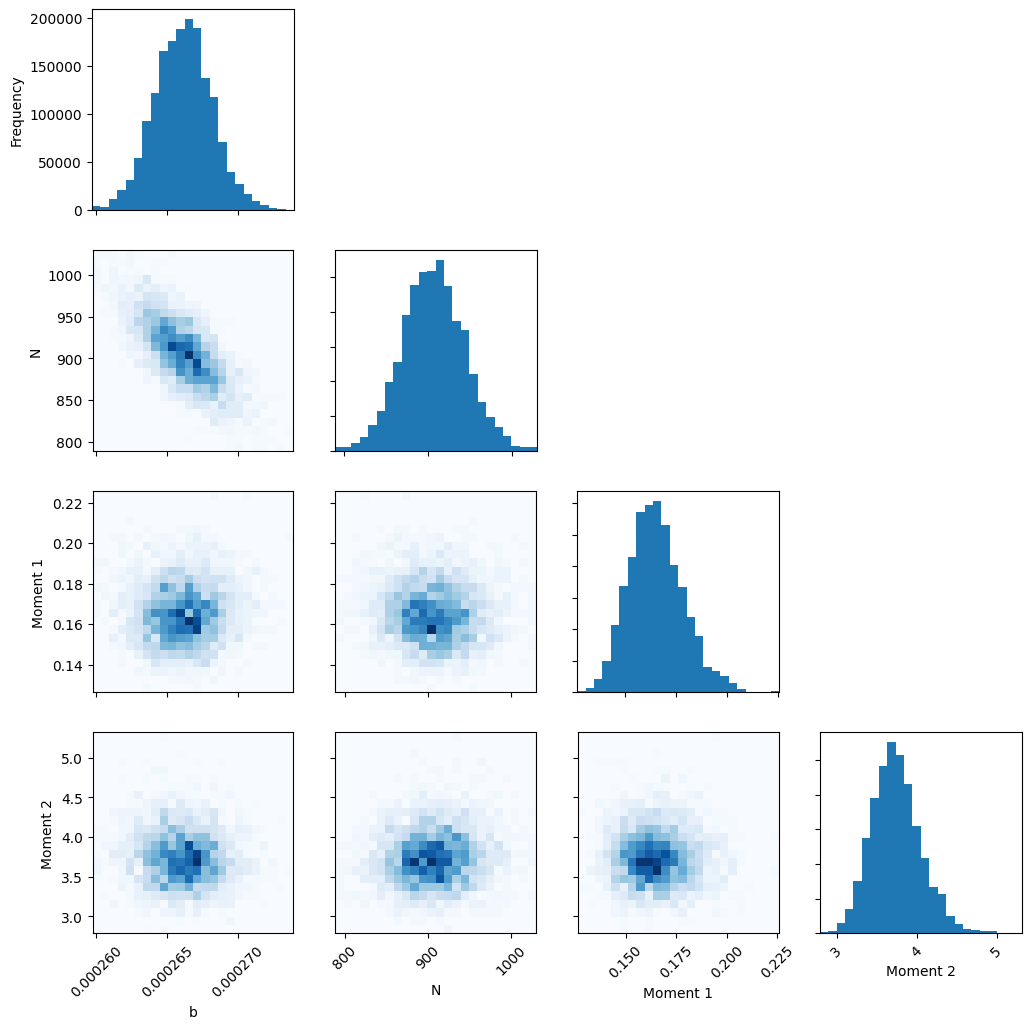

In [10]:


parameter_names = ["b","N", "Moment 1", "Moment 2"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2"])
plt.show()

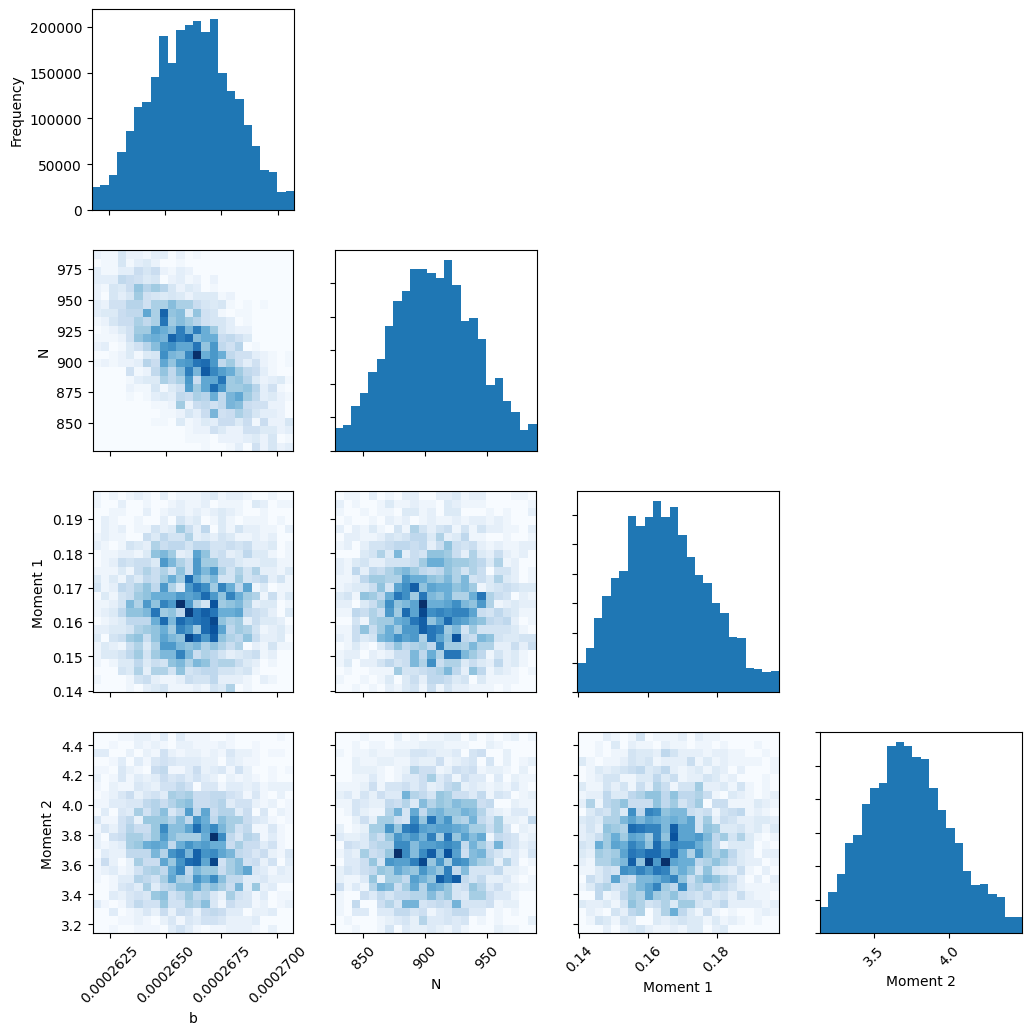

In [11]:
parameter_names = ["b","N", "Moment 1", "Moment 2"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2"],
                    n_percentiles=97)
                    
plt.show()

[2.67408489e-04 8.88709961e+02 1.46810457e-01 3.75713425e+00]


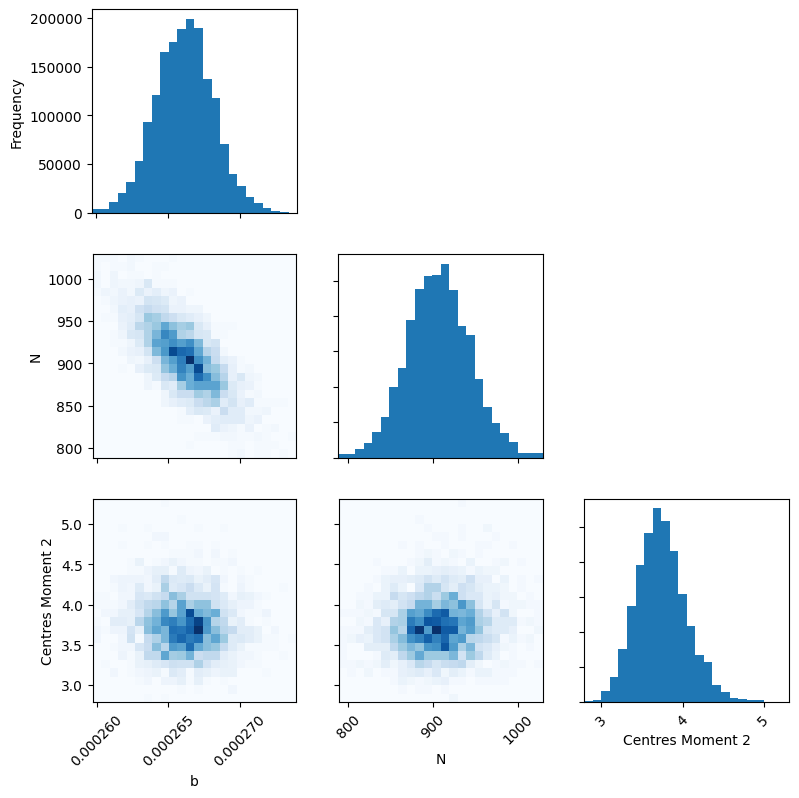

In [12]:
parameter_names = ["b","N", "Moment 2"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3]], heatmap=True, 
                    parameter_names=["b","N", "Centres Moment 2"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [13]:
parameter_names = ["b","N", "Moment 1", "Moment 2"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess      ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  -------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.00    2798.31  0.87
N         909.43  37.21   837.54  884.20  909.15  934.14  983.85   1.00    2790.40  0.86
Moment 1  0.17    0.01    0.14    0.16    0.16    0.17    0.19     1.00    4654.23  1.44
Moment 2  3.75    0.31    3.19    3.53    3.73    3.94    4.42     1.00    4704.20  1.46


In [14]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [15]:

parameter_names = ["b","N", "Moment 1", "Moment 2"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%    rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  --------  -------  ------  --------  --------------
b         0.000266  2.04e-06  0.000262  0.000265  0.000266  0.000267  0.00027  1       2.8e+03   0.866
N         909       37.2      838       884       909       934       984      1       2.79e+03  0.863
Moment 1  0.165     0.0136    0.141     0.156     0.164     0.173     0.195    1       4.65e+03  1.44
Moment 2  3.75      0.311     3.19      3.53      3.73      3.94      4.42     1       4.7e+03   1.46


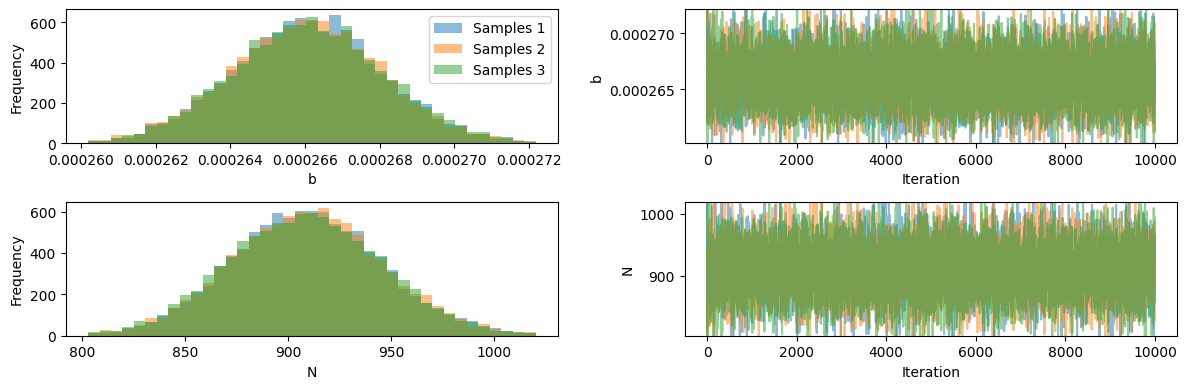

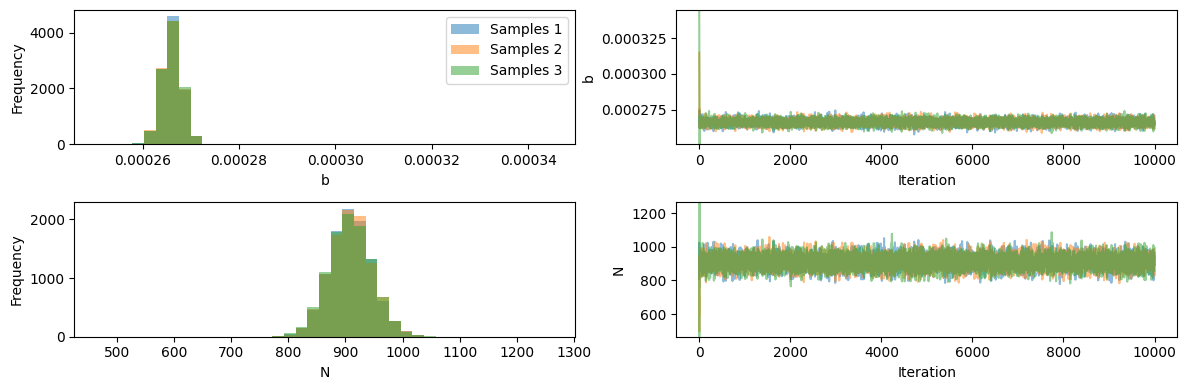

In [16]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()